In [347]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta
from IPython.display import Image

### 1. Experiment Definition

We developed a new webpage and want to test it's effects on purchase conversion. As such we split our users evenly into 2 groups:
1. **Control**: They get the old webpage
2. **Treatment**: They get the new webpage

Metric we want to track:
$$
\text{purchase conversion} = \frac{\text{# Converted Users}}{\text{# Exposed Users}}
$$

We have 3 weeks of logged exposure/conversion data. Let's define these terms:
1. **Exposure**: A user is bucketed as control or treatment and sees their corresponding page for the first time in the experiment duration
2. **Conversion**: An exposed user makes a purchase within 7 days of being first exposed

Questions you should ask when setting up a test:
- How do you think the experiment will fair?
- Do we have actionable next steps laid out?

### 2. Data Collection

Let's use some A/B testing data: https://www.kaggle.com/saraabdelaal/abtestdata

In [348]:
df = pd.read_csv('csv/ab_data.csv')

In [350]:
df.sample(2)

,user_id,timestamp,group,landing_page,converted
265342,741320,2017-01-06 09:10:20.880418,treatment,new_page,0
180296,899025,2017-01-23 16:31:37.030115,control,old_page,0


Each row is logged when user is exposed to a webpage.
- **timestamp**: time the user is first exposed
- **group**: bucket
- **landing_page**: Which page are they seeing
- **converted**: Initialized to 0. Changes to 1 if the user makes a purchase within 7 days of first exposure

In [370]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


### 3. Data Processing

But there are some repeated exposures for some users

In [97]:
sample = df[df['user_id'].isin([746755,722274])]
sample

,user_id,timestamp,group,landing_page,converted
29073,746755,2017-01-11 01:28:57.083669,control,new_page,1
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0
286566,746755,2017-01-05 03:40:08.457451,control,old_page,0


Get First timestamp for each username. In this dataset, it is the timestamp of first conversion, but in reality, make sure to do one of the following:
1. Get timestamp of first exposure
2. Remove users with multiple buckets

In [96]:
# 1. Get timestamp of first exposure
first_conversion = sample.groupby('user_id')['timestamp'].min().to_frame().reset_index()
sample = sample.merge(first_conversion, on=['user_id', 'timestamp'])
sample

,user_id,timestamp,group,landing_page,converted
0,722274,2017-01-09 21:21:23.638444,control,new_page,0
1,746755,2017-01-05 03:40:08.457451,control,old_page,0


In [106]:
counter = df['user_id'].value_counts()
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

3894 (1.34\%) user_ids have been exposed to the old AND new page. It should be okay to remove them

In [371]:
#2. Remove users with multiple buckets
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

In [373]:
# Add week column to see the data as you would during experiment
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
df.sample()

,user_id,timestamp,group,landing_page,converted,week
129391,740710,2017-01-19 22:26:04.950909,control,old_page,0,3


In [374]:
df['week'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64

### 4. Experiment: Frequentist Approach

In [381]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


#### Chi-Squared Test

$$
H_0: \text{Control & Treatment are independent} \\
H_A: \text{Control & Treatment are not independent} 
$$

In [227]:
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [228]:
contingency_table

array([[ 15944, 117010],
       [ 15799, 117428]])

In [229]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [241]:
chi, p_value

(1.1276469852100297, 0.28827779822703054)

Since the p_value > 0.05, we cannot reject null hypothesis. Hence, we cannot conclude if there exists a relationship between the control and treatment groups.

In [238]:
print(f"{round(p_value * 100, 2)}% probability that a more extreme chi square than {round(chi, 3)} would have occured by chance")

28.83% probability that a more extreme chi quare than 1.128 would have occured by chance


But this is tough to interpret. We would to say something about the actual maginitude of lift. Something like this:

In [240]:
print(f"(We CANNOT say this) We are {round(p_value * 100, 2)}% confident that our lift = {lift}%")

(We CANNOT say this) We are 28.83% confident that our lift = -0.133%


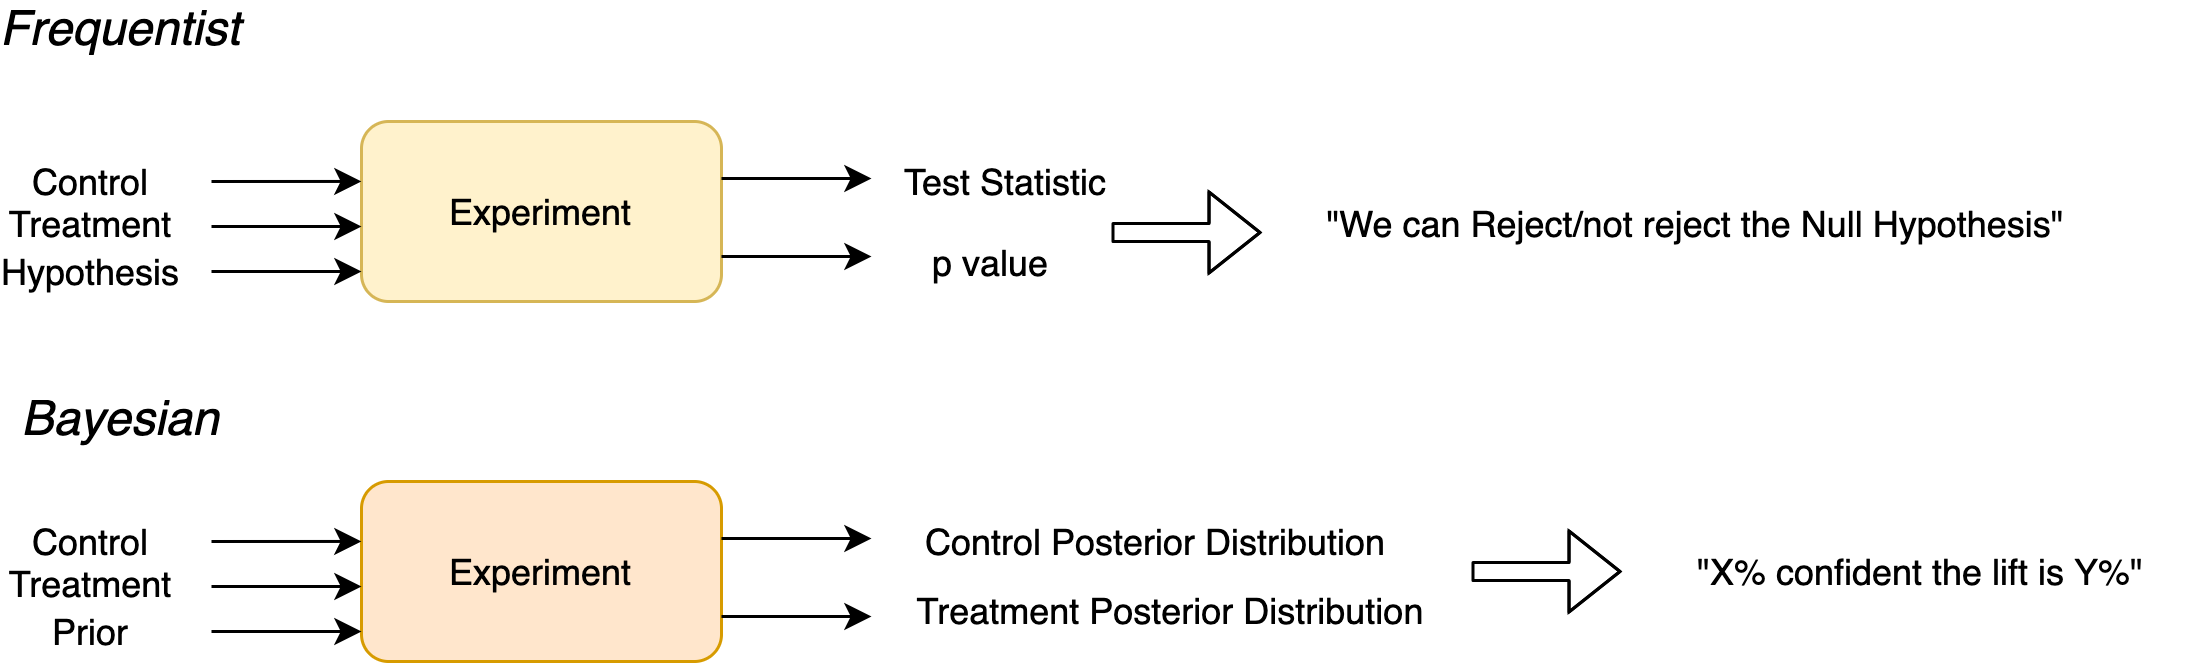

In [247]:
Image(filename='../mics/b_v_f.png') 

### 5. Experiment: Bayesian Approach

We want to input the _prior distribution_ and have the experiment update the parameters to create _posterier distributions_. Since these prior & posterior distributions will be used to sample Conversion Rate, we model them after beta distribtion.

Let's create the prior beta distribtion from the first weeks of conversion data

In [250]:
prior = df[(df['week'] == 1) & (df['group']=='control')]

In [255]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

In [256]:
prior_means[:10]

[0.106, 0.105, 0.137, 0.116, 0.123, 0.12, 0.098, 0.129, 0.122, 0.124]

In [260]:
# Model Beta Distribtion from sample means
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)

In [432]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.909%
Control Conversion Rate: 12.058%
Lift = -0.012%


In [433]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")

Probability that treatment > control: 15.8%


In [434]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12056303255497915, Variance: 1.0333316272670703e-06
Treatment Posterior: Mean: 0.1190944894489385, Variance: 1.0242362170011709e-06


We can even make statements like the following which are actionable:

In [388]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we are seeing a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")

Probability that we are seeing a 2% lift: 0.4%


Advantages of Bayesian over Frequentist:
- Results are more interpretable than the ones we got from the frequentist approach
- We can interpret results at any point during the experiment. Don't need to wait for an arbitrary "statsig"

### References

[1] Good blog to understand Beta Distribution: http://varianceexplained.org/statistics/beta_distribution_and_baseball/

0:00 Introduction
0:56 Define the Experiment
4:25 Data Collection
6:20 Data Processing
8:43 Experiment: The Frequentist Approach
12:50 Experiment: The Bayesian Approach
14:40 Bayesian: Generating Priors
20:06 Bayesian: Generating Posteriors
22:00 Interpreting results
26:00 Bayesian Vs Frequentist